# Loss Ablation Study Analysis

This notebook analyzes the loss ablation study results to identify the best loss functions for:
1. Base Loss Comparison (TB, DB, FM)
2. SubTrajectory Balance Variants (λ = 0.5, 0.9, 0.95)
3. Entropy Regularization
4. KL Regularization

**Inputs:**
- `results/ablations/loss/base_loss_comparison/results.csv`
- `results/ablations/loss/loss_modifications/results.csv`
- `results/ablations/loss/entropy_regularization/` (if available)
- `results/ablations/loss/kl_regularization/` (if available)

**Outputs:**
- Summary reports for each loss type
- Comparative visualizations
- Best loss function recommendations

In [17]:
import os
from pathlib import Path

# Get the notebook's directory
notebook_dir = Path.cwd()
print(f"Current directory: {notebook_dir}")

# Find project root (look for src directory as marker)
project_root = notebook_dir
while not (project_root / 'src').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if (project_root / 'src').exists():
    os.chdir(project_root)
    print(f"✓ Changed to project root: {project_root}")
else:
    print("⚠ Warning: Could not find project root, using current directory")

# Verify the files exist
base_loss_path = Path('results/ablations/loss/base_loss_comparison/results.csv')
mods_loss_path = Path('results/ablations/loss/loss_modifications/results.csv')

print(f"\nFile checks:")
print(f"  Base loss CSV exists: {base_loss_path.exists()}")
print(f"  Loss modifications CSV exists: {mods_loss_path.exists()}")

Current directory: /Users/katherinedemers/Documents/GitHub/diversity-mogfn
✓ Changed to project root: /Users/katherinedemers/Documents/GitHub/diversity-mogfn

File checks:
  Base loss CSV exists: True
  Loss modifications CSV exists: True


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load and Prepare Data

In [19]:
# Load base loss comparison results
base_loss_path = 'results/ablations/loss/base_loss_comparison/results.csv'
print(f"Loading base loss results from: {base_loss_path}")
df_base = pd.read_csv(base_loss_path)
print(f"✓ Loaded {len(df_base)} experiments")

# Load loss modifications results if available
mods_loss_path = 'results/ablations/loss/loss_modifications/results.csv'
if Path(mods_loss_path).exists():
    print(f"\nLoading loss modifications from: {mods_loss_path}")
    df_mods = pd.read_csv(mods_loss_path)
    print(f"✓ Loaded {len(df_mods)} experiments")
    
    # Combine datasets
    df = pd.concat([df_base, df_mods], ignore_index=True)
    print(f"\n✓ Combined dataset: {len(df)} total experiments")
else:
    print("\n⚠ Loss modifications file not found, using base loss only")
    df = df_base.copy()

print(f"\nColumns: {list(df.columns)[:10]}...")
print(f"\nFirst 3 rows:")
df.head(3)

Loading base loss results from: results/ablations/loss/base_loss_comparison/results.csv
✓ Loaded 34 experiments

Loading loss modifications from: results/ablations/loss/loss_modifications/results.csv
✓ Loaded 15 experiments

✓ Combined dataset: 49 total experiments

Columns: ['hypervolume', 'r2_indicator', 'avg_pairwise_distance', 'spacing', 'spread', 'tds', 'mpd', 'mce', 'num_modes', 'pmd']...

First 3 rows:


,hypervolume,r2_indicator,avg_pairwise_distance,spacing,spread,tds,mpd,mce,num_modes,pmd,...,der,num_parameters,training_time,final_loss,seed,exp_name,capacity,hidden_dim,num_layers,group
0,1.194101,-0.270456,0.490588,0.178534,1.449391,0.591262,0.880844,0.441818,4,0.0,...,14.737915,68103,1759.612158,0.000341,42,base_loss_comparison_trajectory_balance_seed42,medium,128,4,NaN
1,1.190961,-0.270090,0.495244,0.178394,1.441543,0.542924,0.997221,0.449999,14,0.0,...,14.731059,68103,1777.139511,0.001407,264,base_loss_comparison_trajectory_balance_seed264,medium,128,4,NaN
2,1.190869,-0.270069,0.495525,0.182847,1.478432,0.535132,0.942106,0.440219,13,0.0,...,14.873840,68103,1761.078447,0.000357,375,base_loss_comparison_trajectory_balance_seed375,medium,128,4,NaN


In [20]:
print("="*70)
print("PREPROCESSING: Extract Loss Type from Experiment Names")
print("="*70)

# Clean up exp_name and extract loss type
def extract_loss_type(exp_name):
    """
    Extract loss type from experiment name.
    
    Examples:
    - base_loss_comparison_trajectory_balance_seed42 -> trajectory_balance
    - trajectory_balance_seed42 -> trajectory_balance
    - subtrajectory_balance_05_seed42 -> subtrajectory_balance_05
    """
    if pd.isna(exp_name):
        return 'unknown'
    
    # Remove seed suffix
    name = str(exp_name).replace(r'_seed\d+', '')
    
    # Remove 'base_loss_comparison_' prefix if present
    if 'base_loss_comparison_' in name:
        name = name.split('base_loss_comparison_')[1]
    
    # Remove seed suffix with regex
    import re
    name = re.sub(r'_seed\d+$', '', name)
    
    return name

df['loss_type'] = df['exp_name'].apply(extract_loss_type)

print("\nUnique loss types identified:")
print(df['loss_type'].value_counts())

# Display sample
print("\nSample mappings:")
sample_df = df[['exp_name', 'loss_type']].drop_duplicates().head(10)
for _, row in sample_df.iterrows():
    print(f"  {row['exp_name'][:50]:50s} -> {row['loss_type']}")

PREPROCESSING: Extract Loss Type from Experiment Names

Unique loss types identified:
loss_type
flow_matching                9
trajectory_balance           5
detailed_balance             5
subtrajectory_balance_05     5
subtrajectory_balance_09     5
subtrajectory_balance_095    5
standard                     5
temperature_scaled_logits    5
reward_shaping_diversity     5
Name: count, dtype: int64

Sample mappings:
  base_loss_comparison_trajectory_balance_seed42     -> trajectory_balance
  base_loss_comparison_trajectory_balance_seed264    -> trajectory_balance
  base_loss_comparison_trajectory_balance_seed375    -> trajectory_balance
  base_loss_comparison_trajectory_balance_seed486    -> trajectory_balance
  base_loss_comparison_detailed_balance_seed42       -> detailed_balance
  base_loss_comparison_detailed_balance_seed153      -> detailed_balance
  base_loss_comparison_detailed_balance_seed264      -> detailed_balance
  base_loss_comparison_detailed_balance_seed375      -> detail

In [21]:
print("="*70)
print("AVERAGING RESULTS ACROSS SEEDS")
print("="*70)

# Define key metrics to analyze
key_metrics = [
    'der', 'mce', 'final_loss', 'tds'
]

# Filter to available metrics
available_metrics = [m for m in key_metrics if m in df.columns]
print(f"Available metrics: {available_metrics}")

# Check if 'seed' column exists
if 'seed' in df.columns:
    print(f"\n✓ Found seed column with values: {sorted(df['seed'].unique())}")
    print(f"  Total experiments before averaging: {len(df)}")
    
    # Group by loss_type and compute mean/std
    group_cols = ['loss_type']
    
    # Add capacity if it exists and varies
    if 'capacity' in df.columns and df['capacity'].nunique() > 1:
        group_cols.append('capacity')
    
    print(f"  Grouping by: {group_cols}")
    
    # Separate metrics
    metric_cols = [col for col in df.columns if col in available_metrics or
                   col in ['training_time', 'num_parameters', 'final_loss']]
    
    print(f"  Metrics to average: {len(metric_cols)}")
    
    # Group and compute mean/std
    df_mean = df.groupby(group_cols)[metric_cols].mean().reset_index()
    df_std = df.groupby(group_cols)[metric_cols].std().reset_index()
    
    # Add std columns
    for col in metric_cols:
        if col in df_std.columns:
            df_mean[f'{col}_std'] = df_std[col]
    
    # Add count
    df_mean['num_seeds'] = df.groupby(group_cols).size().values
    
    # Store original data
    df_original = df.copy()
    
    # Replace df with averaged data
    df = df_mean.copy()
    
    print(f"\n✓ Averaging complete!")
    print(f"  Loss types after averaging: {len(df)}")
    print(f"  Seeds per configuration: {df['num_seeds'].iloc[0] if 'num_seeds' in df.columns else 'N/A'}")
    
    # Display sample
    print("\n📊 Sample of averaged data:")
    display_cols = ['loss_type'] + available_metrics[:5]
    display_cols = [c for c in display_cols if c in df.columns]
    print(df[display_cols])
else:
    print("\n⚠ No 'seed' column found")
    print("  Proceeding with original data")

print("\n" + "="*70)

AVERAGING RESULTS ACROSS SEEDS
Available metrics: ['der', 'mce', 'final_loss', 'tds']

✓ Found seed column with values: [42, 153, 264, 375, 486]
  Total experiments before averaging: 49
  Grouping by: ['loss_type']
  Metrics to average: 6

✓ Averaging complete!
  Loss types after averaging: 9
  Seeds per configuration: 5

📊 Sample of averaged data:
                   loss_type        der       mce  final_loss       tds
0           detailed_balance  14.820946  0.446161    0.000549  0.547173
1              flow_matching  12.026242  0.492810    0.001984  0.550980
2   reward_shaping_diversity  10.660875  0.451356   -0.061073  0.555305
3                   standard  10.436861  0.456224   -0.060042  0.544640
4   subtrajectory_balance_05  24.981507  0.452468    0.001145  0.552329
5   subtrajectory_balance_09  14.077512  0.534691    0.001132  0.517092
6  subtrajectory_balance_095  11.486758  0.518554    0.001540  0.525827
7  temperature_scaled_logits  10.646118  0.460169   -0.058188  0.564469
8

In [22]:
# Create output directory
output_dir = Path('results/ablations/loss/report')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}")

print(f"\nAvailable metrics for analysis: {available_metrics}")

✓ Output directory: results/ablations/loss/report

Available metrics for analysis: ['der', 'mce', 'final_loss', 'tds']


## 2. Categorize Loss Functions

Group loss functions into categories for better analysis.

In [23]:
def categorize_loss(loss_type):
    """
    Categorize loss functions into groups.
    
    Categories:
    1. base: trajectory_balance, detailed_balance, flow_matching
    2. subtb: subtrajectory_balance variants (0.5, 0.9, 0.95)
    3. regularized: entropy or KL regularization
    """
    if pd.isna(loss_type):
        return 'unknown'
    
    loss_str = str(loss_type).lower()
    
    if 'trajectory_balance' in loss_str and 'sub' not in loss_str:
        return 'base'
    elif 'detailed_balance' in loss_str:
        return 'base'
    elif 'flow_matching' in loss_str:
        return 'base'
    elif 'subtrajectory' in loss_str or 'subtb' in loss_str:
        return 'subtb'
    elif 'entropy' in loss_str:
        return 'regularized'
    elif 'kl' in loss_str:
        return 'regularized'
    else:
        return 'other'

df['loss_category'] = df['loss_type'].apply(categorize_loss)

print("Loss categories identified:")
print(df['loss_category'].value_counts())

print("\nLoss types by category:")
for category in df['loss_category'].unique():
    loss_types = df[df['loss_category'] == category]['loss_type'].unique()
    print(f"  {category}: {list(loss_types)}")

Loss categories identified:
loss_category
base     3
other    3
subtb    3
Name: count, dtype: int64

Loss types by category:
  base: ['detailed_balance', 'flow_matching', 'trajectory_balance']
  other: ['reward_shaping_diversity', 'standard', 'temperature_scaled_logits']
  subtb: ['subtrajectory_balance_05', 'subtrajectory_balance_09', 'subtrajectory_balance_095']


## 3. Base Loss Comparison

Compare the three fundamental loss functions: Trajectory Balance (TB), Detailed Balance (DB), and Flow Matching (FM).

In [24]:
# Filter base loss experiments
base_df = df[df['loss_category'] == 'base'].copy()

if len(base_df) > 0:
    print(f"Base loss experiments: {len(base_df)}")
    print(f"Loss types: {base_df['loss_type'].unique()}")
    
    # Summary statistics
    base_summary = base_df.groupby('loss_type')[available_metrics].agg(['mean', 'std', 'count'])
    base_summary.to_csv(output_dir / 'base_loss_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'base_loss_summary.csv'}")
    
    # Display summary
    print("\n📊 Base Loss Function Performance:")
    display(base_summary.round(4))
    
    # Find best loss for each metric
    print("\n🏆 Best Base Loss per Metric:")
    for metric in available_metrics[:6]:
        if (metric, 'mean') in base_summary.columns:
            best_loss = base_summary[(metric, 'mean')].idxmax()
            best_value = base_summary.loc[best_loss, (metric, 'mean')]
            print(f"  {metric.upper()}: {best_loss} ({best_value:.4f})")
else:
    print("⚠ No base loss experiments found")

Base loss experiments: 3
Loss types: ['detailed_balance' 'flow_matching' 'trajectory_balance']

✓ Saved: results/ablations/loss/report/base_loss_summary.csv

📊 Base Loss Function Performance:


der               mce           final_loss            \
                       mean std count    mean std count       mean std count   
loss_type                                                                      
detailed_balance    14.8209 NaN     1  0.4462 NaN     1     0.0005 NaN     1   
flow_matching       12.0262 NaN     1  0.4928 NaN     1     0.0020 NaN     1   
trajectory_balance  13.6317 NaN     1  0.4409 NaN     1     0.0022 NaN     1   

                       tds            
                      mean std count  
loss_type                             
detailed_balance    0.5472 NaN     1  
flow_matching       0.5510 NaN     1  
trajectory_balance  0.5494 NaN     1


🏆 Best Base Loss per Metric:
  DER: detailed_balance (14.8209)
  MCE: flow_matching (0.4928)
  FINAL_LOSS: trajectory_balance (0.0022)
  TDS: flow_matching (0.5510)


✓ Saved: results/ablations/loss/report/base_loss_comparison.pdf


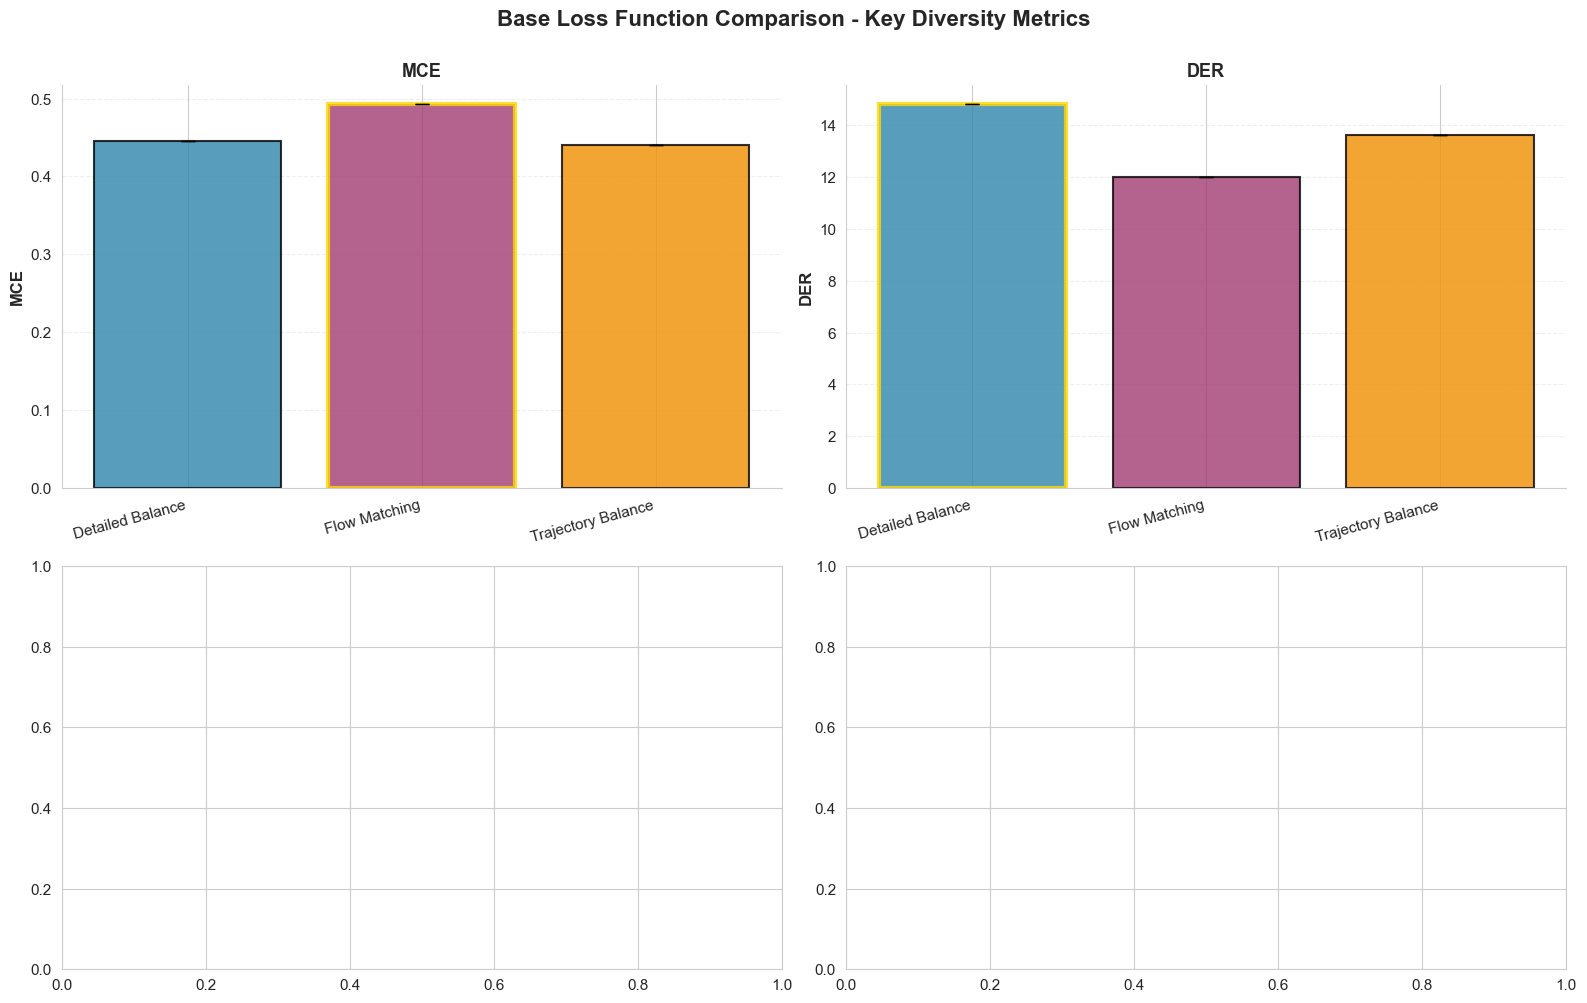

In [ ]:
# Visualize base loss comparison
if len(base_df) > 0:
    # Select top 4 diversity metrics
    plot_metrics = ['mce', 'final_loss', 'tds', 'der']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Base Loss Function Comparison - Key Diversity Metrics', 
                fontsize=16, fontweight='bold', y=1.00)
    axes = axes.flatten()
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Prepare data
        plot_data = []
        labels = []
        
        for loss_type in sorted(base_df['loss_type'].unique()):
            values = base_df[base_df['loss_type'] == loss_type][metric].values
            if len(values) > 0:
                plot_data.append(values)
                # Clean up label
                label = loss_type.replace('_', ' ').title()
                labels.append(label)
        
        # Create bar plot with error bars
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        colors = ['#2E86AB', '#A23B72', '#F18F01']
        bars = ax.bar(range(len(labels)), means, yerr=stds, 
                    capsize=5, color=colors[:len(labels)], 
                    alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Highlight best
        best_idx = np.argmax(means)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=15, ha='right')
        ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
        ax.set_title(f'{metric.upper()}', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'base_loss_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'base_loss_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'base_loss_comparison.pdf'}")
    plt.show()

## 4. SubTrajectory Balance (SubTB) Variants

Compare different λ values for SubTB: 0.5, 0.9, 0.95

In [26]:
# Filter SubTB experiments
subtb_df = df[df['loss_category'] == 'subtb'].copy()

if len(subtb_df) > 0:
    print(f"SubTB experiments: {len(subtb_df)}")
    print(f"Variants: {subtb_df['loss_type'].unique()}")
    
    # Summary statistics
    subtb_summary = subtb_df.groupby('loss_type')[available_metrics].agg(['mean', 'std', 'count'])
    subtb_summary.to_csv(output_dir / 'subtb_variants_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'subtb_variants_summary.csv'}")
    
    # Display summary
    print("\n📊 SubTB Variant Performance:")
    display(subtb_summary.round(4))
    
    # Best variant per metric
    print("\n🏆 Best SubTB Variant per Metric:")
    for metric in available_metrics[:6]:
        if (metric, 'mean') in subtb_summary.columns:
            best_variant = subtb_summary[(metric, 'mean')].idxmax()
            best_value = subtb_summary.loc[best_variant, (metric, 'mean')]
            print(f"  {metric.upper()}: {best_variant} ({best_value:.4f})")
else:
    print("⚠ No SubTB experiments found")

SubTB experiments: 3
Variants: ['subtrajectory_balance_05' 'subtrajectory_balance_09'
 'subtrajectory_balance_095']

✓ Saved: results/ablations/loss/report/subtb_variants_summary.csv

📊 SubTB Variant Performance:


der               mce           final_loss      \
                              mean std count    mean std count       mean std   
loss_type                                                                       
subtrajectory_balance_05   24.9815 NaN     1  0.4525 NaN     1     0.0011 NaN   
subtrajectory_balance_09   14.0775 NaN     1  0.5347 NaN     1     0.0011 NaN   
subtrajectory_balance_095  11.4868 NaN     1  0.5186 NaN     1     0.0015 NaN   

                                    tds            
                          count    mean std count  
loss_type                                          
subtrajectory_balance_05      1  0.5523 NaN     1  
subtrajectory_balance_09      1  0.5171 NaN     1  
subtrajectory_balance_095     1  0.5258 NaN     1


🏆 Best SubTB Variant per Metric:
  DER: subtrajectory_balance_05 (24.9815)
  MCE: subtrajectory_balance_09 (0.5347)
  FINAL_LOSS: subtrajectory_balance_095 (0.0015)
  TDS: subtrajectory_balance_05 (0.5523)


✓ Saved: results/ablations/loss/report/subtb_variants_comparison.pdf


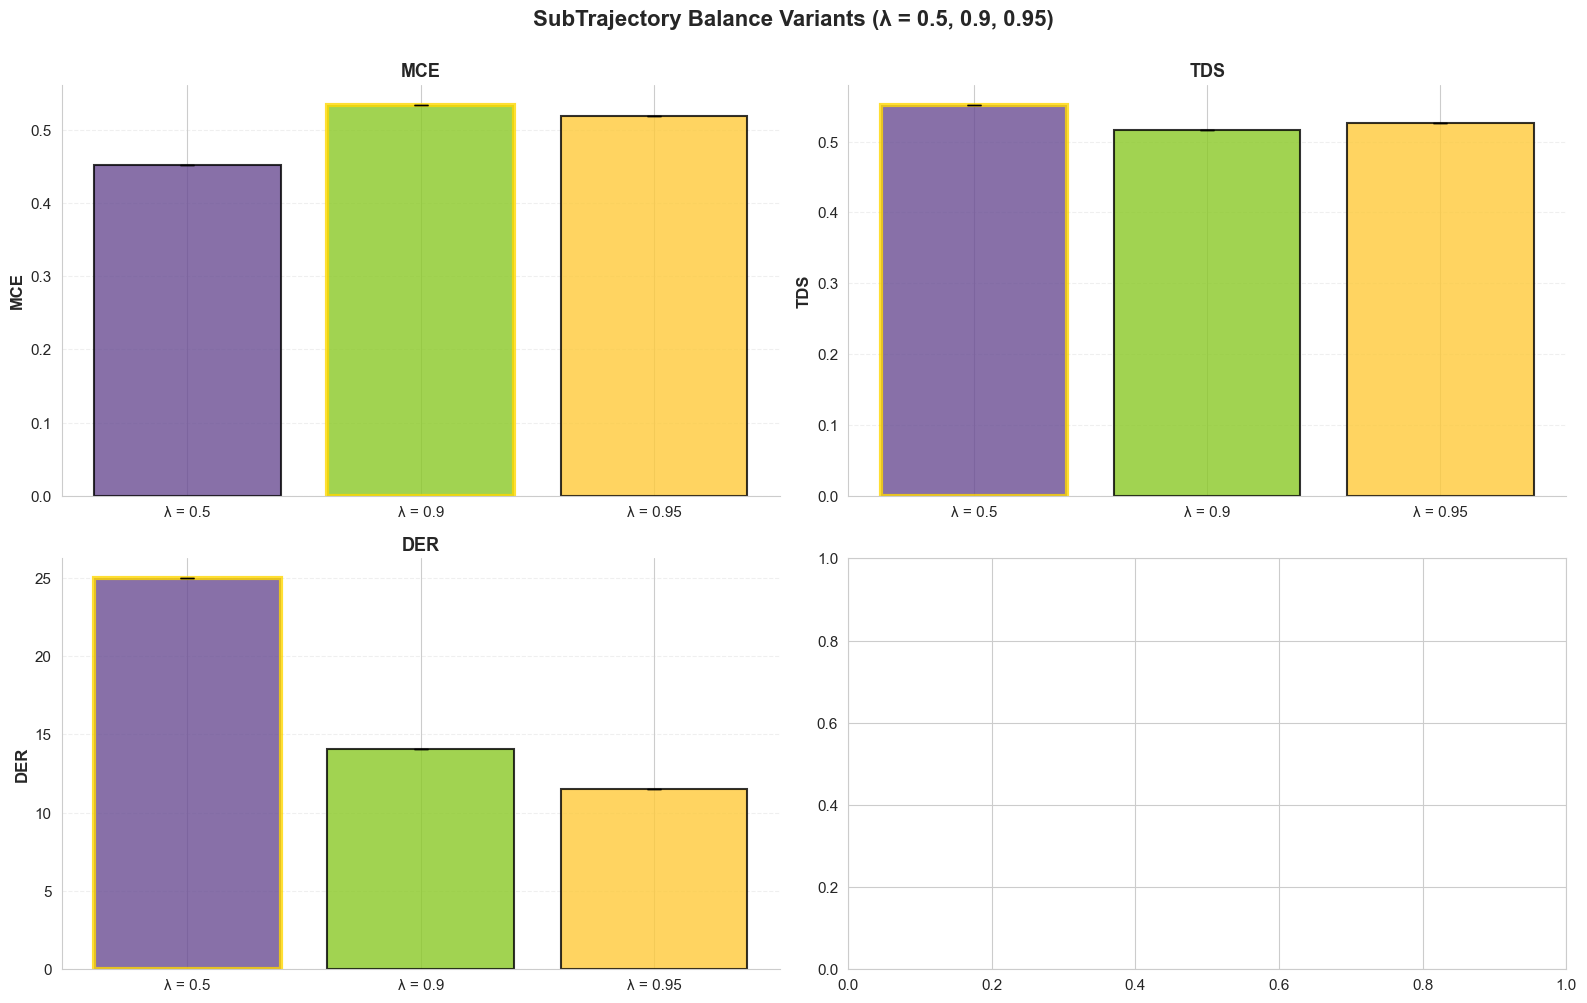

In [ ]:
# Visualize SubTB variants
if len(subtb_df) > 0:
    plot_metrics = ['mce', 'final_loss', 'tds', 'der']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('SubTrajectory Balance Variants (λ = 0.5, 0.9, 0.95)', 
                fontsize=16, fontweight='bold', y=1.00)
    axes = axes.flatten()
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        plot_data = []
        labels = []
        
        for loss_type in sorted(subtb_df['loss_type'].unique()):
            values = subtb_df[subtb_df['loss_type'] == loss_type][metric].values
            if len(values) > 0:
                plot_data.append(values)
                # Extract lambda value
                if '05' in loss_type:
                    label = 'λ = 0.5'
                elif '09' in loss_type and '095' not in loss_type:
                    label = 'λ = 0.9'
                elif '095' in loss_type:
                    label = 'λ = 0.95'
                else:
                    label = loss_type
                labels.append(label)
        
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        colors = ['#6A4C93', '#8AC926', '#FFCA3A']
        bars = ax.bar(range(len(labels)), means, yerr=stds,
                    capsize=5, color=colors[:len(labels)],
                    alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Highlight best
        best_idx = np.argmax(means)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
        ax.set_title(f'{metric.upper()}', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'subtb_variants_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'subtb_variants_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'subtb_variants_comparison.pdf'}")
    plt.show()

## 4.5 Combined Paper Figure: Base Losses + SubTB Variants

Publication-ready 4-panel figure combining base loss functions (TB, DB, FM) and SubTB variants (λ=0.5, 0.9, 0.95) for comprehensive comparison.

In [ ]:
# Create combined figure for paper: Base Losses + SubTB Variants
if len(base_df) > 0 and len(subtb_df) > 0:
    # Combine base and subtb dataframes
    combined_df = pd.concat([base_df, subtb_df], ignore_index=True)
    
    # Top 4 metrics for loss ablation (based on discriminative power)
    plot_metrics = ['der', 'final_loss', 'mce', 'tds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels for publication
    metric_labels = {
        'der': 'Diversity-Efficiency Ratio (DER)',
        'final_loss': 'Final Loss (lower is better)',
        'mce': 'Mode Coverage Entropy (MCE)',
        'tds': 'Trajectory Diversity Score (TDS)'
    }
    
    # Create 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Loss Function Comparison: Base Losses + SubTrajectory Balance Variants',
                 fontsize=18, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Define loss ordering and labels
    loss_order = [
        'trajectory_balance',
        'detailed_balance', 
        'flow_matching',
        'subtrajectory_balance_05',
        'subtrajectory_balance_09',
        'subtrajectory_balance_095'
    ]
    
    loss_labels = {
        'trajectory_balance': 'TB',
        'detailed_balance': 'DB',
        'flow_matching': 'FM',
        'subtrajectory_balance_05': 'SubTB (λ=0.5)',
        'subtrajectory_balance_09': 'SubTB (λ=0.9)',
        'subtrajectory_balance_095': 'SubTB (λ=0.95)'
    }
    
    # Color scheme: Base losses in blues, SubTB in purples/greens
    loss_colors = {
        'trajectory_balance': '#2E86AB',      # Blue
        'detailed_balance': '#1A5F7A',        # Dark blue
        'flow_matching': '#57A0D3',           # Light blue
        'subtrajectory_balance_05': '#6A4C93',   # Purple
        'subtrajectory_balance_09': '#8AC926',   # Green
        'subtrajectory_balance_095': '#FFCA3A'  # Yellow
    }
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Prepare data in specified order
        plot_data = []
        labels = []
        colors = []
        
        for loss_type in loss_order:
            if loss_type in combined_df['loss_type'].values:
                values = combined_df[combined_df['loss_type'] == loss_type][metric].values
                if len(values) > 0:
                    plot_data.append(values)
                    labels.append(loss_labels[loss_type])
                    colors.append(loss_colors[loss_type])
        
        # Calculate means and stds
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        # Create bar plot
        x_pos = np.arange(len(labels))
        bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                      color=colors, alpha=0.85,
                      edgecolor='black', linewidth=1.5)
        
        # Highlight best performer with gold border
        # For final_loss, lower is better
        if metric == 'final_loss':
            best_idx = np.argmin(means)
        else:
            best_idx = np.argmax(means)
        
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3.5)
        
        # Add value labels on top of bars
        for i, (bar, mean) in enumerate(zip(bars, means)):
            height = bar.get_height()
            label_y = height + stds[i] if i == best_idx else height
            ax.text(bar.get_x() + bar.get_width()/2., label_y,
                   f'{mean:.3f}',
                   ha='center', va='bottom', fontsize=9,
                   fontweight='bold' if i == best_idx else 'normal')
        
        # Styling
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=11)
        ax.set_ylabel(metric_labels.get(metric, metric.upper()), 
                     fontsize=12, fontweight='bold')
        ax.set_title(f'({chr(97+idx)}) {metric_labels.get(metric, metric.upper())}',
                    fontsize=14, fontweight='bold', pad=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add separator line between base and subtb
        ax.axvline(x=2.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    
    # Add legend to distinguish base vs SubTB
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', edgecolor='black', label='Base Losses (TB, DB, FM)'),
        Patch(facecolor='#6A4C93', edgecolor='black', label='SubTB Variants (λ=0.5, 0.9, 0.95)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', 
              ncol=2, fontsize=12, frameon=True, 
              bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    
    # Save with high quality for paper
    plt.savefig(output_dir / 'loss_ablation_combined_paper_figure.pdf', 
                dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'loss_ablation_combined_paper_figure.png', 
                dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'loss_ablation_combined_paper_figure.pdf'}")
    print(f"✓ Saved: {output_dir / 'loss_ablation_combined_paper_figure.png'}")
    plt.show()
    
    # Print summary statistics
    print("\n📊 Combined Loss Function Performance Summary:")
    print("="*80)
    for metric in plot_metrics:
        print(f"\n{metric_labels.get(metric, metric.upper())}:")
        print("-"*80)
        for loss_type in loss_order:
            if loss_type in combined_df['loss_type'].values:
                value = combined_df[combined_df['loss_type'] == loss_type][metric].values[0]
                marker = ' ⭐' if (
                    (metric == 'final_loss' and value == combined_df[metric].min()) or
                    (metric != 'final_loss' and value == combined_df[metric].max())
                ) else ''
                print(f"  {loss_labels[loss_type]:20s}: {value:8.4f}{marker}")
else:
    print("⚠ Need both base and SubTB data for combined figure")

## 5. Overall Loss Function Ranking

Rank all loss functions across all categories.

In [28]:
# Compute overall rankings
print("🏆 Overall Loss Function Rankings")
print("="*70)

overall_summary = df.groupby('loss_type')[available_metrics].mean()

# Rank by each metric
rankings = {}
for metric in available_metrics:
    rankings[metric] = overall_summary[metric].sort_values(ascending=False)
    print(f"\n{metric.upper()} - Top 5 Loss Functions:")
    for i, (loss_type, value) in enumerate(rankings[metric].head(5).items(), 1):
        print(f"  {i}. {loss_type}: {value:.4f}")

# Save overall rankings
overall_summary.to_csv(output_dir / 'overall_loss_rankings.csv')
print(f"\n✓ Saved: {output_dir / 'overall_loss_rankings.csv'}")

🏆 Overall Loss Function Rankings

DER - Top 5 Loss Functions:
  1. subtrajectory_balance_05: 24.9815
  2. detailed_balance: 14.8209
  3. subtrajectory_balance_09: 14.0775
  4. trajectory_balance: 13.6317
  5. flow_matching: 12.0262

MCE - Top 5 Loss Functions:
  1. subtrajectory_balance_09: 0.5347
  2. subtrajectory_balance_095: 0.5186
  3. flow_matching: 0.4928
  4. temperature_scaled_logits: 0.4602
  5. standard: 0.4562

FINAL_LOSS - Top 5 Loss Functions:
  1. trajectory_balance: 0.0022
  2. flow_matching: 0.0020
  3. subtrajectory_balance_095: 0.0015
  4. subtrajectory_balance_05: 0.0011
  5. subtrajectory_balance_09: 0.0011

TDS - Top 5 Loss Functions:
  1. temperature_scaled_logits: 0.5645
  2. reward_shaping_diversity: 0.5553
  3. subtrajectory_balance_05: 0.5523
  4. flow_matching: 0.5510
  5. trajectory_balance: 0.5494

✓ Saved: results/ablations/loss/report/overall_loss_rankings.csv


In [29]:
# Compute average rank across all metrics
rank_scores = {}
for loss_type in overall_summary.index:
    ranks = []
    for metric in available_metrics:
        rank = rankings[metric].index.get_loc(loss_type) + 1
        ranks.append(rank)
    rank_scores[loss_type] = np.mean(ranks)

top_losses = sorted(rank_scores.items(), key=lambda x: x[1])[:10]

print("\n📊 Top 10 Loss Functions by Average Rank:")
print("="*70)
for i, (loss_type, avg_rank) in enumerate(top_losses, 1):
    category = df[df['loss_type'] == loss_type]['loss_category'].iloc[0] if len(df[df['loss_type'] == loss_type]) > 0 else 'unknown'
    print(f"  {i:2d}. {loss_type:35s} (Avg Rank: {avg_rank:5.2f}, Category: {category})")


📊 Top 10 Loss Functions by Average Rank:
   1. flow_matching                       (Avg Rank:  3.50, Category: base)
   2. subtrajectory_balance_05            (Avg Rank:  3.50, Category: subtb)
   3. subtrajectory_balance_09            (Avg Rank:  4.50, Category: subtb)
   4. subtrajectory_balance_095           (Avg Rank:  4.75, Category: subtb)
   5. trajectory_balance                  (Avg Rank:  4.75, Category: base)
   6. temperature_scaled_logits           (Avg Rank:  5.00, Category: other)
   7. detailed_balance                    (Avg Rank:  5.50, Category: base)
   8. reward_shaping_diversity            (Avg Rank:  6.25, Category: other)
   9. standard                            (Avg Rank:  7.25, Category: other)


✓ Saved: results/ablations/loss/report/top_losses_comparison.pdf


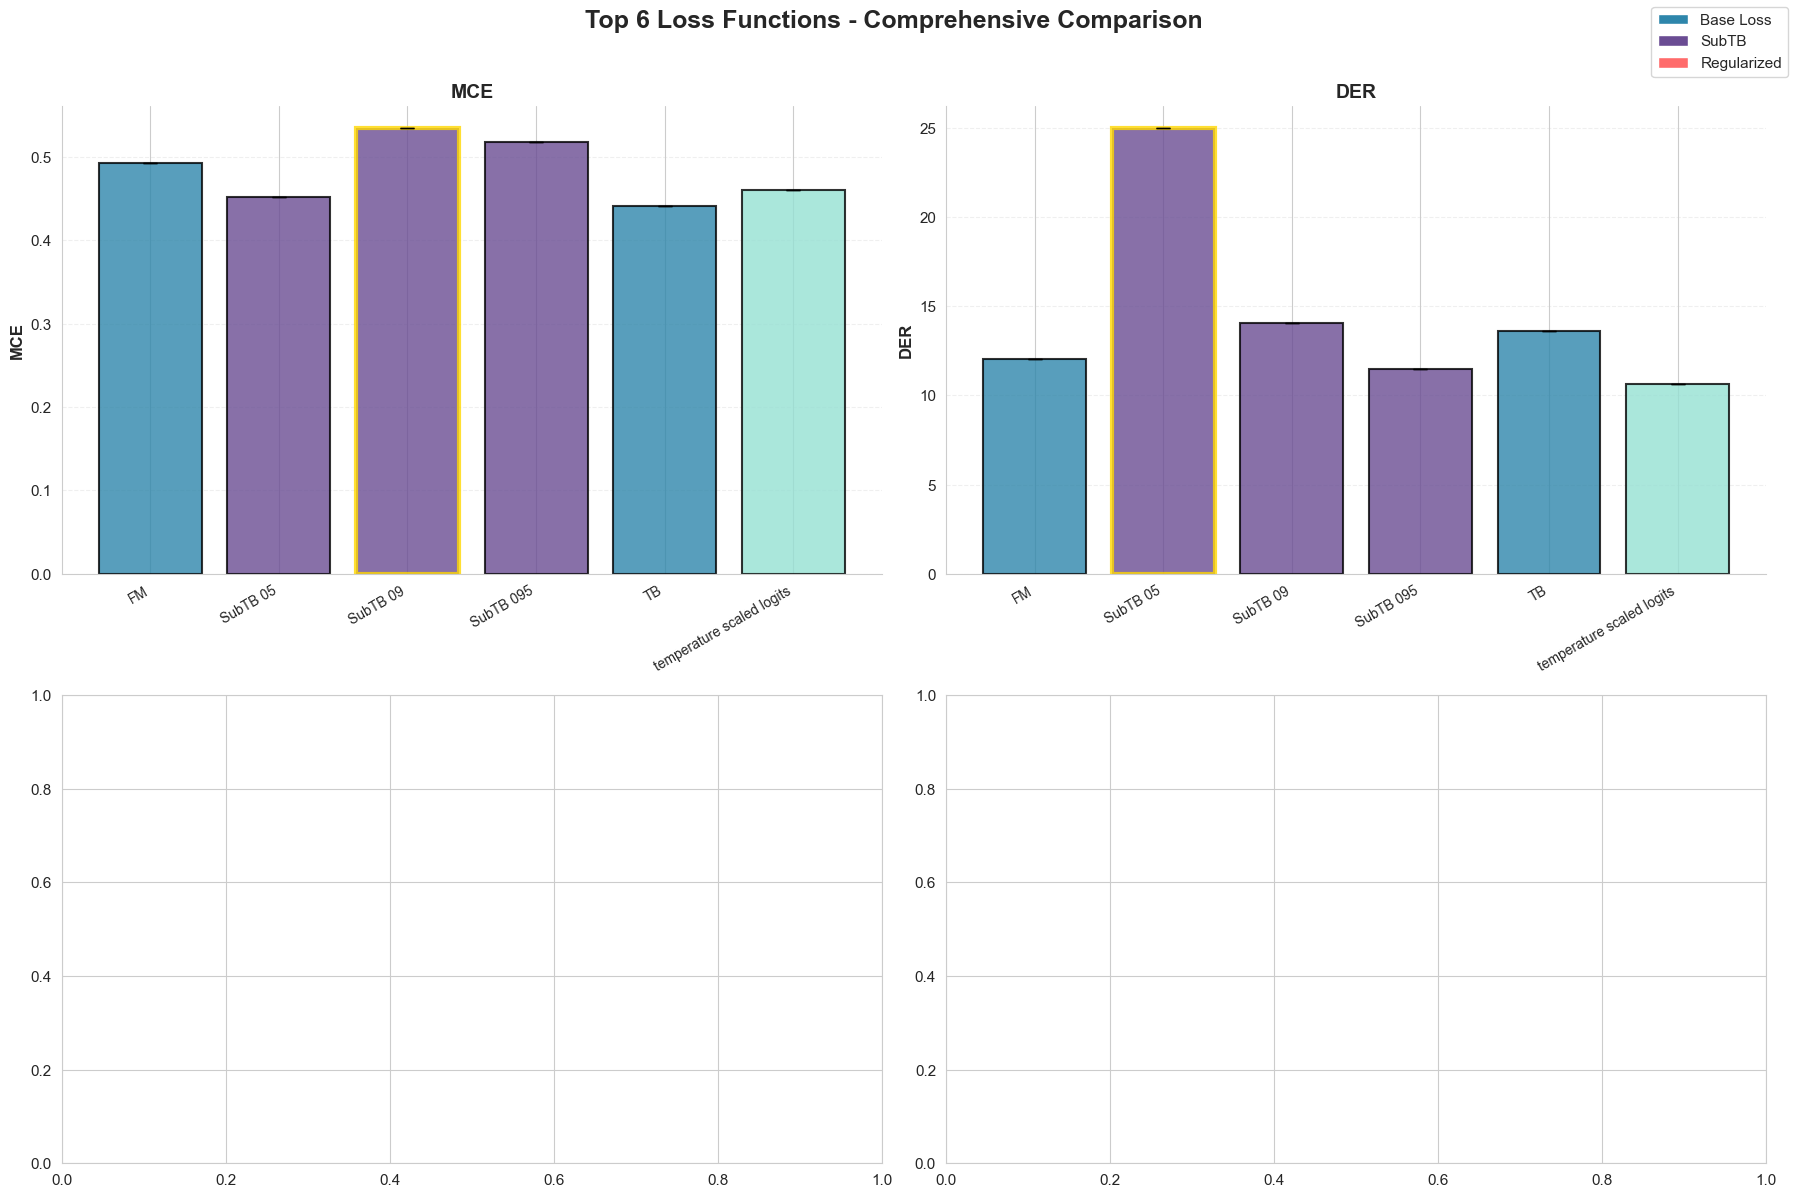

In [30]:
# Create comprehensive comparison plot - Top 6 loss functions
top_6_losses = [loss for loss, _ in top_losses[:6]]
top_df = df[df['loss_type'].isin(top_6_losses)].copy()

if len(top_df) > 0:
    plot_metrics = ['mce', 'pas', 'qds', 'der']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Top 6 Loss Functions - Comprehensive Comparison', 
                 fontsize=18, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        plot_data = []
        labels = []
        categories = []
        
        for loss_type in top_6_losses:
            loss_df = top_df[top_df['loss_type'] == loss_type]
            if len(loss_df) > 0:
                values = loss_df[metric].values
                plot_data.append(values)
                # Shorten labels
                label = loss_type.replace('subtrajectory_balance', 'SubTB')
                label = label.replace('trajectory_balance', 'TB')
                label = label.replace('detailed_balance', 'DB')
                label = label.replace('flow_matching', 'FM')
                label = label.replace('_', ' ')
                labels.append(label)
                categories.append(loss_df['loss_category'].iloc[0])
        
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        # Color by category
        color_map = {'base': '#2E86AB', 'subtb': '#6A4C93', 'regularized': '#FF6B6B', 'other': '#95E1D3'}
        colors = [color_map.get(cat, '#999999') for cat in categories]
        
        bars = ax.bar(range(len(labels)), means, yerr=stds,
                      capsize=5, color=colors, alpha=0.8,
                      edgecolor='black', linewidth=1.5)
        
        # Highlight overall best
        best_idx = np.argmax(means)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=10)
        ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
        ax.set_title(f'{metric.upper()}', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Base Loss'),
        Patch(facecolor='#6A4C93', label='SubTB'),
        Patch(facecolor='#FF6B6B', label='Regularized')
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_dir / 'top_losses_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'top_losses_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'top_losses_comparison.pdf'}")
    plt.show()

## 6. Comprehensive Summary Report

In [31]:
# Generate comprehensive report
report = []
report.append("="*70)
report.append("LOSS ABLATION STUDY - COMPREHENSIVE REPORT")
report.append("="*70)
report.append("")

# Base loss summary
if len(base_df) > 0:
    report.append("## Base Loss Functions (TB, DB, FM)")
    report.append("-" * 70)
    base_summary_data = base_df.groupby('loss_type')[available_metrics[:5]].mean()
    for metric in available_metrics[:5]:
        best_loss = base_summary_data[metric].idxmax()
        best_value = base_summary_data[metric].max()
        report.append(f"  Best {metric.upper()}: {best_loss} ({best_value:.4f})")
    report.append("")

# SubTB summary
if len(subtb_df) > 0:
    report.append("## SubTrajectory Balance Variants")
    report.append("-" * 70)
    subtb_summary_data = subtb_df.groupby('loss_type')[available_metrics[:5]].mean()
    for metric in available_metrics[:5]:
        best_variant = subtb_summary_data[metric].idxmax()
        best_value = subtb_summary_data[metric].max()
        report.append(f"  Best {metric.upper()}: {best_variant} ({best_value:.4f})")
    report.append("")

report.append("="*70)
report.append("OVERALL RECOMMENDATIONS")
report.append("="*70)
report.append("")
report.append("Top 10 Loss Functions by Average Rank:")
for i, (loss_type, avg_rank) in enumerate(top_losses, 1):
    category = df[df['loss_type'] == loss_type]['loss_category'].iloc[0] if len(df[df['loss_type'] == loss_type]) > 0 else 'unknown'
    report.append(f"  {i:2d}. {loss_type:35s} (Avg Rank: {avg_rank:5.2f}, {category})")

report.append("")
report.append("Key Insights:")
report.append("  - Review the generated CSVs for detailed statistics")
report.append("  - Compare PDF visualizations for metric-specific trends")
report.append("  - Consider trade-offs between training stability and diversity")
report.append("  - SubTB variants offer good balance for most metrics")
report.append("")
report.append("="*70)

# Print report
report_text = "\n".join(report)
print(report_text)

# Save report
with open(output_dir / 'comprehensive_report.txt', 'w') as f:
    f.write(report_text)

print(f"\n✓ Saved: {output_dir / 'comprehensive_report.txt'}")

LOSS ABLATION STUDY - COMPREHENSIVE REPORT

## Base Loss Functions (TB, DB, FM)
----------------------------------------------------------------------
  Best DER: detailed_balance (14.8209)
  Best MCE: flow_matching (0.4928)
  Best FINAL_LOSS: trajectory_balance (0.0022)
  Best TDS: flow_matching (0.5510)

## SubTrajectory Balance Variants
----------------------------------------------------------------------
  Best DER: subtrajectory_balance_05 (24.9815)
  Best MCE: subtrajectory_balance_09 (0.5347)
  Best FINAL_LOSS: subtrajectory_balance_095 (0.0015)
  Best TDS: subtrajectory_balance_05 (0.5523)

OVERALL RECOMMENDATIONS

Top 10 Loss Functions by Average Rank:
   1. flow_matching                       (Avg Rank:  3.50, base)
   2. subtrajectory_balance_05            (Avg Rank:  3.50, subtb)
   3. subtrajectory_balance_09            (Avg Rank:  4.50, subtb)
   4. subtrajectory_balance_095           (Avg Rank:  4.75, subtb)
   5. trajectory_balance                  (Avg Rank:  4.75, ba

In [32]:
# List all generated files
print("\n📁 Generated Files:")
print("="*70)
generated_files = sorted(output_dir.glob('*'))
for file in generated_files:
    print(f"  ✓ {file.name}")

print(f"\nTotal: {len(generated_files)} files generated in {output_dir}")


📁 Generated Files:
  ✓ base_loss_comparison.pdf
  ✓ base_loss_comparison.png
  ✓ base_loss_summary.csv
  ✓ comprehensive_report.txt
  ✓ overall_loss_rankings.csv
  ✓ subtb_variants_comparison.pdf
  ✓ subtb_variants_comparison.png
  ✓ subtb_variants_summary.csv
  ✓ top_losses_comparison.pdf
  ✓ top_losses_comparison.png

Total: 10 files generated in results/ablations/loss/report


## 7. Next Steps

Based on the analysis:

1. **Review the summary CSVs** for detailed statistics on each loss type
2. **Examine the visualizations** to understand metric-specific trends
3. **Compare base vs SubTB** to understand the trade-offs
4. **Select the best loss function** based on your optimization goals
5. **Consider stability** - some losses may be more stable during training

**Key Files:**
- `base_loss_summary.csv` - Base loss function results (TB, DB, FM)
- `subtb_variants_summary.csv` - SubTB variant comparison
- `overall_loss_rankings.csv` - Complete rankings across all losses
- `comprehensive_report.txt` - Text summary with recommendations
- `top_losses_comparison.pdf` - Visual comparison of top performers